**Read ME**

---
---

When the project is shared with you it will be inside your `Shared with me` folder, there will be a folder named `Collab Notebooks`
inside the folder there will be another folder called `dataset`
and a Jupyter Notebook file called `Predicting Status of Kickstarter Projects.ipynb`.

Please move the data set to your root folder, i.e. in `My Drive`
other wise, you need to modify the `data_folder_name` below.

You will be asked to mount your drive, 
* Please select run anyway,
* click the link, 
* choose the google account which this notebook has been shared with 
* allow,
* copy the code and paste the code in the input box

the drive should be mounted

In [ ]:
# change the folder name if necessary
data_folder_name = '/content/drive/My Drive/dataset'

# mount your google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# import pandas and numpy
import pandas as pd
import numpy as np

# import matplotlib and sns
import matplotlib.pyplot as plt
import seaborn as sns

# LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Train Test Split
from sklearn.model_selection import train_test_split

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# storing data files in an array
import os
data_files = []
for root, dirs, files in os.walk(data_folder_name):
    for file in files:
        data_files.append(os.path.join(root, file))

# sorted based on file names
data_files = sorted(data_files)
# read all the files at one go
df = pd.concat(pd.read_csv(f) for f in data_files)


Need to drop columns with very few values
* friends, 
* is_backing, 
* is_starred, 
* permissions
These 4 columns has only 96 distinct non-null values out of nearly 0.2 Million rows

There are other columns which are irrelevant to the status of the projects. This will be droopped


In [ ]:
columns_with_few_values = [
    'friends', 
    'is_backing', 
    'is_starred', 
    'permissions'
]

# drop columns with little useful data
columns_with_not_useful_data = [
        'id', # doesn't provide value
        'name', # doesn't provide value: name of the kickstarter project
        'blurb', # doesn't provide value
        'slug', # similar to blurb
        'creator', # doesn't provide value
        'profile', # creator's kickstarter profile
        'source_url', # doesn't provide value
        'urls', # doesn't provide value
        'photo', # doesn't provide value
        'location', # more nuanced location: will be using country instead
]

columns_to_drop = columns_with_not_useful_data + columns_with_few_values

df.drop(columns=columns_to_drop, inplace=True)

Create two new columns
* category_name, 
* parent_category_name
from category attributes


In [ ]:

# get parent category
def get_parent_category(category):
    c = eval(category)
    return c.get('parent_name') or c.get('name')

df = df.assign(category_name=df['category'].apply(lambda category: eval(category)['name']))

# get parent name from category
# sometimes parent_name is omitted, due to the fact that it is the same as category name.

df = df.assign(parent_category_name=df['category'].apply(get_parent_category))
# now we can drop category object column
df.drop(columns=['category'], inplace=True)
df.head()

,backers_count,converted_pledged_amount,country,country_displayable_name,created_at,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,goal,is_starrable,launched_at,pledged,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_type,category_name,parent_category_name
0,4,41,US,the United States,1512430228,USD,$,True,USD,1515102534,False,1.0,150.0,False,1512510534,41.0,False,False,failed,1515102534,1.0,41.0,international,DIY,Crafts
1,35,2205,US,the United States,1528377129,USD,$,True,USD,1531325825,False,1.0,900.0,False,1528733825,2205.0,True,False,successful,1531325825,1.0,2205.0,international,Woodworking,Crafts
2,310,8861,US,the United States,1443014021,USD,$,True,USD,1447620375,False,1.0,8500.0,False,1443728775,8861.0,True,False,successful,1447620376,1.0,8861.0,international,Spaces,Dance
3,1,100,US,the United States,1412436646,USD,$,True,USD,1415406440,False,1.0,50000.0,False,1412810840,100.0,False,False,failed,1415406440,1.0,100.0,international,DIY,Crafts
4,36,1026,US,the United States,1599615992,USD,$,True,USD,1602385860,False,1.0,800.0,False,1600148240,1026.0,True,True,successful,1602385860,1.0,1026.0,international,Candles,Crafts


In [ ]:
# create synthetic column project_duration_day
sec_per_day = 86400

# project_duration_day = (deadline - created_at) / (86400)
df['project_duration'] = (df['deadline'] - df['created_at']) / sec_per_day
df['project_duration'] = df['project_duration'].apply(np.ceil)

# per_day_usd_req = goal / project_duration
df['per_day_usd_req'] = df['goal'] / df['project_duration']

# per_day_usd_pledged = converted_pledged_amount / project_duration
df['per_day_usd_pledged'] = df['converted_pledged_amount'] / df['project_duration']

df.head()

,backers_count,converted_pledged_amount,country,country_displayable_name,created_at,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,goal,is_starrable,launched_at,pledged,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_type,category_name,parent_category_name,project_duration,per_day_usd_req,per_day_usd_pledged
0,4,41,US,the United States,1512430228,USD,$,True,USD,1515102534,False,1.0,150.0,False,1512510534,41.0,False,False,failed,1515102534,1.0,41.0,international,DIY,Crafts,31.0,4.838710,1.322581
1,35,2205,US,the United States,1528377129,USD,$,True,USD,1531325825,False,1.0,900.0,False,1528733825,2205.0,True,False,successful,1531325825,1.0,2205.0,international,Woodworking,Crafts,35.0,25.714286,63.000000
2,310,8861,US,the United States,1443014021,USD,$,True,USD,1447620375,False,1.0,8500.0,False,1443728775,8861.0,True,False,successful,1447620376,1.0,8861.0,international,Spaces,Dance,54.0,157.407407,164.092593
3,1,100,US,the United States,1412436646,USD,$,True,USD,1415406440,False,1.0,50000.0,False,1412810840,100.0,False,False,failed,1415406440,1.0,100.0,international,DIY,Crafts,35.0,1428.571429,2.857143
4,36,1026,US,the United States,1599615992,USD,$,True,USD,1602385860,False,1.0,800.0,False,1600148240,1026.0,True,True,successful,1602385860,1.0,1026.0,international,Candles,Crafts,33.0,24.242424,31.090909


In [ ]:
columns_to_encode = [
    'category_name', 
    'parent_category_name', 
    'country', 
    'country_displayable_name', 
    'currency_symbol', 
    'current_currency',
    'usd_type',
    'currency',
    'disable_communication',
    
]

for column in columns_to_encode:
    print(column)
    df[column] = LabelEncoder().fit_transform(df[column].astype(str))

category_name
parent_category_name
country
country_displayable_name
currency_symbol
current_currency
usd_type
currency
disable_communication


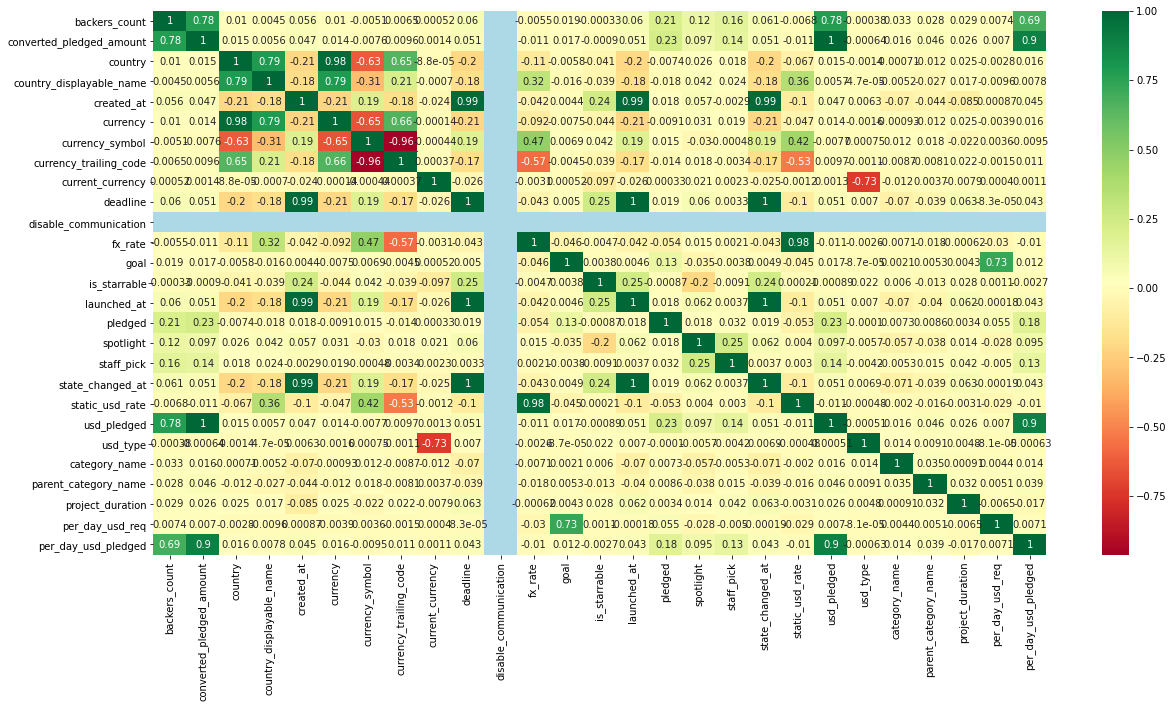

In [ ]:
plt.figure(figsize=(20,10))
corr = df.corr()
color = plt.get_cmap('RdYlGn')   
color.set_bad('lightblue')
sns.heatmap(corr, annot=True, cmap=color)
plt.show()

In [ ]:
single_value_columns = ['disable_communication']
for column in single_value_columns:
    df.drop(columns=[column], inplace=True)

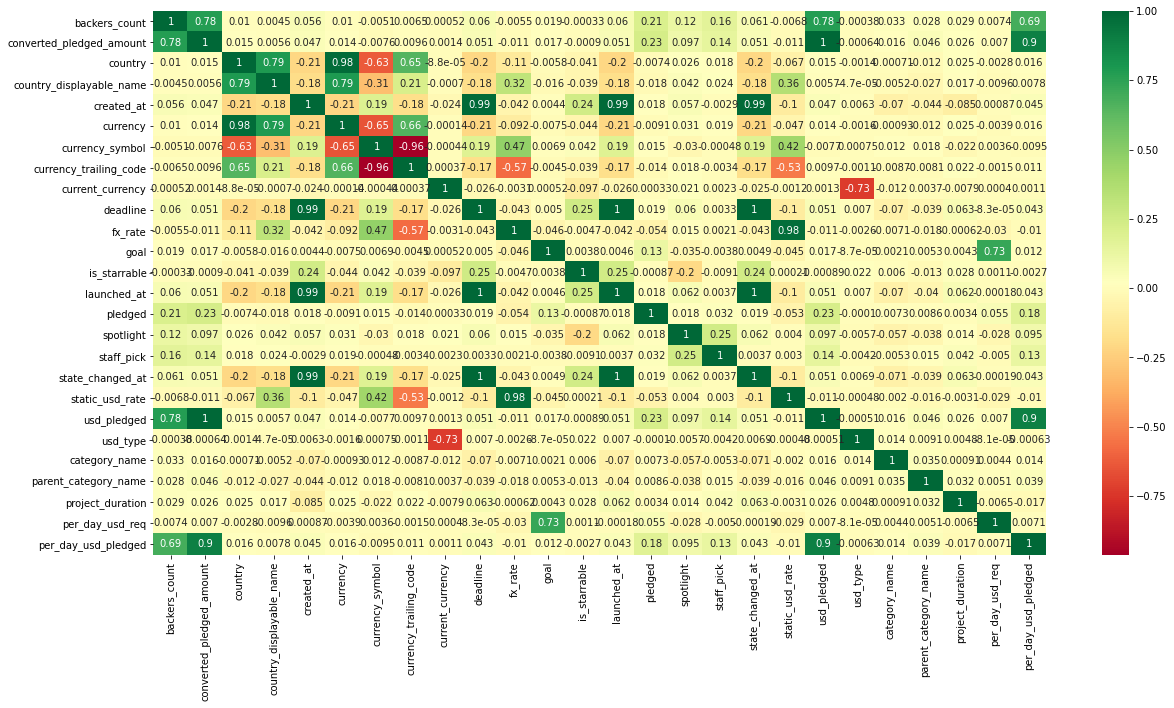

In [ ]:
plt.figure(figsize=(20,10))
corr = df.corr()
color = plt.get_cmap('RdYlGn')   
color.set_bad('lightblue')
sns.heatmap(corr, annot=True, cmap=color)
plt.show()

Correlation Method will output heavily correlated columns, we used 90% correlation, change the `correlated_features = correlation(df, .9)` `.9` to something else, if you need to fine tune


In [ ]:
def correlation(dataset, threshold):
    correlated_columns = set()
    matrix = dataset.corr()
    for i in range(len(matrix.columns)):
        for j in range(i):
            if (matrix.iloc[i, j]) > threshold:
                correlated_columns.add(matrix.columns[i])
    return correlated_columns

correlated_features = correlation(df, .9)
correlated_features

{'currency',
 'deadline',
 'launched_at',
 'state_changed_at',
 'static_usd_rate',
 'usd_pledged'}

In [ ]:
# drop columns based on correlation matrix output
columns_to_drop = [
    'currency_trailing_code',
    'currency',
    'deadline',
    'launched_at',
    'state_changed_at',
    'static_usd_rate',
    'usd_pledged',
    'created_at'
]
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,backers_count,converted_pledged_amount,country,country_displayable_name,currency_symbol,current_currency,fx_rate,goal,is_starrable,pledged,spotlight,staff_pick,state,usd_type,category_name,parent_category_name,project_duration,per_day_usd_req,per_day_usd_pledged
0,4,41,24,24,0,2,1.0,150.0,False,41.0,False,False,failed,1,34,2,31.0,4.838710,1.322581
1,35,2205,24,24,0,2,1.0,900.0,False,2205.0,True,False,successful,1,152,2,35.0,25.714286,63.000000
2,310,8861,24,24,0,2,1.0,8500.0,False,8861.0,True,False,successful,1,132,3,54.0,157.407407,164.092593
3,1,100,24,24,0,2,1.0,50000.0,False,100.0,False,False,failed,1,34,2,35.0,1428.571429,2.857143
4,36,1026,24,24,0,2,1.0,800.0,False,1026.0,True,True,successful,1,17,2,33.0,24.242424,31.090909


In [ ]:
# initialize holding variables

training_accuracy_list = {}
accuracy_list = {}
precision_list = {}
recall_list = {}
f1_list = {}
roc_auc_list = {}
classification_reports = {}

In [ ]:
# get rid of status column
y = df['state']
df.drop(labels=["state"], axis=1, inplace=True)

In [ ]:
# Controls the shuffling applied to the data before applying the split. 
# Pass an int for reproducible output across multiple function calls
# 70/30 training/testing split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=10)

### Decision Tree

Accuracy of the training model: 0.9990569066538245
Accuracy of the model: 0.9292235661334374
Recall of the model: 0.9292235661334374
Precision of the model: 0.9327346339335251
F1 score: 0.930935961484046
ROC score: 0.8764498820583728
{'canceled': {'precision': 0.19143239625167335, 'recall': 0.2141520029951329, 'f1-score': 0.20215585792542853, 'support': 2671}, 'failed': {'precision': 0.9016914307074105, 'recall': 0.8884489664380093, 'f1-score': 0.895021218375345, 'support': 21721}, 'live': {'precision': 0.9919137466307277, 'recall': 0.992984349703184, 'f1-score': 0.9924487594390508, 'support': 1853}, 'successful': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 37830}, 'accuracy': 0.9292235661334374, 'macro avg': {'precision': 0.771259393397453, 'recall': 0.7738963297840815, 'f1-score': 0.7724064589349561, 'support': 64075}, 'weighted avg': {'precision': 0.9327346339335251, 'recall': 0.9292235661334374, 'f1-score': 0.930935961484046, 'support': 64075}}


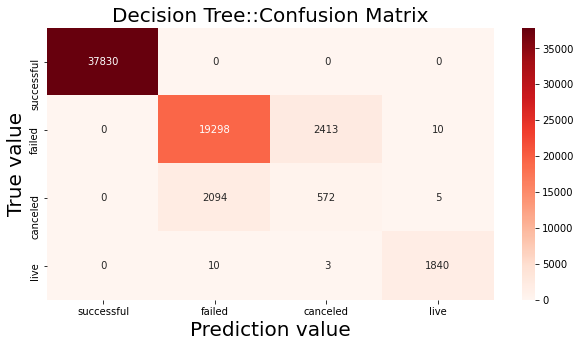

In [ ]:
from sklearn.metrics import \
classification_report,\
accuracy_score, \
precision_score, \
recall_score, \
f1_score, \
roc_auc_score,\
plot_roc_curve, \
roc_curve
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(random_state=0).fit(X_train , y_train)
y_predict = DT.predict(X_test)

accuracy_training = DT.score(X_train, y_train)
accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)
recall = recall_score(y_true=y_test, y_pred=y_predict, average='weighted')
precision = precision_score(y_true=y_test, y_pred=y_predict,average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_predict, average="weighted")
roc_auc = roc_auc_score(y_test, DT.predict_proba(X_test), multi_class='ovr')

key = 'decision_tree'
training_accuracy_list[key] = accuracy_training
accuracy_list[key] = accuracy
precision_list[key] = precision
recall_list[key] = recall
f1_list[key] = f1
roc_auc_list[key] = roc_auc
classification_reports[key] = classification_report(y_test, y_predict, output_dict=True)

print('Accuracy of the training model: ' + str(accuracy_training))
print('Accuracy of the model: ' + str(accuracy))
print('Recall of the model: ' + str(recall))
print('Precision of the model: ' + str(precision))
print('F1 score: ' + str(f1))
print('ROC score: ' + str(roc_auc))
print(classification_reports['decision_tree'])

labels=['successful', 'failed', 'canceled', 'live']
plt.figure(figsize=(10,5))
cf = confusion_matrix(y_true=y_test, y_pred=y_predict, labels=labels)
sns.heatmap(cf,fmt='2d', annot=True,cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediction value',fontsize=20)
plt.ylabel('True value',fontsize=20)
plt.title('Decision Tree::Confusion Matrix',fontsize=20)
plt.show()

### Random Forest


Training Accuracy: 0.9570815450643777
Accuracy: 0.9570815450643777
Precision of the model: 0.9368893323327087
Recall of the model: 0.9570815450643777
F1: 0.9403985414118685
ROC_AUC: 0.964733782137176
{'canceled': {'precision': 0.359504132231405, 'recall': 0.03257207038562336, 'f1-score': 0.05973223480947477, 'support': 2671}, 'failed': {'precision': 0.8926827249399885, 'recall': 0.993002163804613, 'f1-score': 0.9401739206241964, 'support': 21721}, 'live': {'precision': 0.9989136338946225, 'recall': 0.9924446842957366, 'f1-score': 0.9956686518678939, 'support': 1853}, 'successful': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 37830}, 'accuracy': 0.9570815450643777, 'macro avg': {'precision': 0.812775122766504, 'recall': 0.7545047296214933, 'f1-score': 0.7488937018253913, 'support': 64075}, 'weighted avg': {'precision': 0.9368893323327087, 'recall': 0.9570815450643777, 'f1-score': 0.9403985414118685, 'support': 64075}}


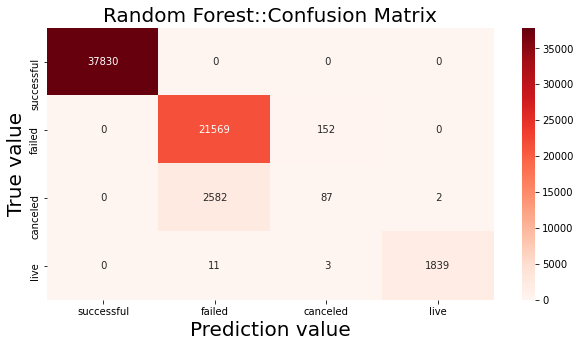

In [ ]:
#Random Forest algorithm
from sklearn.ensemble import RandomForestClassifier
RDF = RandomForestClassifier(n_estimators=200, random_state=10).fit(X_train, y_train)
y_predict = RDF.predict(X_test)

accuracy_training = RDF.score(X_test, y_test, sample_weight=None)
accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)
precision = precision_score(y_true=y_test, y_pred=y_predict, average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_predict, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_predict, average='weighted')
roc_auc = roc_auc_score(y_test, RDF.predict_proba(X_test), multi_class='ovr')

key = 'random_forest'
training_accuracy_list[key] = accuracy_training
accuracy_list[key] = accuracy
precision_list[key] = precision
recall_list[key] = recall
f1_list[key] = f1
roc_auc_list[key] = roc_auc
classification_reports[key] = classification_report(y_test, y_predict, output_dict=True)

print('Training Accuracy: ' + str(accuracy_training))
print('Accuracy: ' + str(accuracy))
print('Precision of the model: ' + str(precision))
print('Recall of the model: ' + str(recall))
print('F1: ' + str(f1))
print('ROC_AUC: ' + str(roc_auc))
print(classification_reports['random_forest'])

# Confusion matrix
plt.figure(figsize=(10,5))
cf = confusion_matrix(y_true=y_test, y_pred=y_predict, labels=labels)
sns.heatmap(cf,fmt='2d', annot=True, cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediction value',fontsize=20)
plt.ylabel('True value',fontsize=20)
plt.title('Random Forest::Confusion Matrix',fontsize=20)
plt.show()

### K-Nearest Neighbour

Training Accuracy: 0.9048614904408896
Accuracy: 0.9048614904408896
Precision: 0.8794551634957855
Recall: 0.9048614904408896
F1: 0.8909884444995094
ROC_AUC: 0.8383986978351647
{'canceled': {'precision': 0.11174089068825911, 'recall': 0.05166604268064395, 'f1-score': 0.07066052227342551, 'support': 2671}, 'failed': {'precision': 0.8584616693610142, 'recall': 0.9290087933336403, 'f1-score': 0.8923430694054436, 'support': 21721}, 'live': {'precision': 0.1601423487544484, 'recall': 0.09713977334052887, 'f1-score': 0.12092710782667117, 'support': 1853}, 'successful': {'precision': 0.9809473959696414, 'recall': 0.9908009516256939, 'f1-score': 0.9858495528669121, 'support': 37830}, 'accuracy': 0.9048614904408896, 'macro avg': {'precision': 0.5278230761933408, 'recall': 0.5171538902451267, 'f1-score': 0.5174450630931131, 'support': 64075}, 'weighted avg': {'precision': 0.8794551634957855, 'recall': 0.9048614904408896, 'f1-score': 0.8909884444995094, 'support': 64075}}


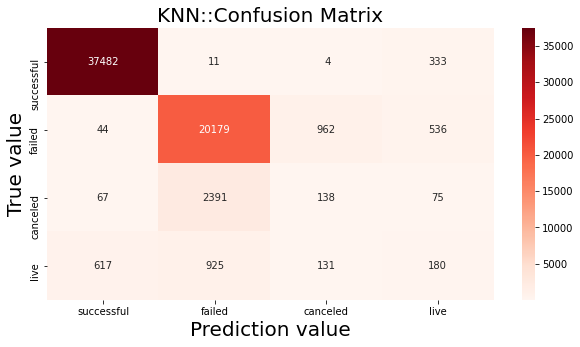

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
y_predict = KNN.predict(X_test)

accuracy_training = KNN.score(X_test, y_test, sample_weight=None)
accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)
precision = precision_score(y_true=y_test, y_pred=y_predict,average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_predict, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_predict, average='weighted')
roc_auc = roc_auc_score(y_test, KNN.predict_proba(X_test), multi_class='ovr')

key = 'knn'
training_accuracy_list[key] = accuracy_training
accuracy_list[key] = accuracy
precision_list[key] = precision
recall_list[key] = recall
f1_list[key] = f1
roc_auc_list[key] = roc_auc
classification_reports[key] = classification_report(y_test, y_predict, output_dict=True)

print('Training Accuracy: ' + str(accuracy_training))
print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1: ' + str(f1))
print('ROC_AUC: ' + str(roc_auc))
print(classification_reports['knn'])

# Confusion matrix
plt.figure(figsize=(10,5))
cf = confusion_matrix(y_true=y_test, y_pred=y_predict, labels=labels)
sns.heatmap(cf,fmt='2d', annot=True, cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediction value',fontsize=20)
plt.ylabel('True value',fontsize=20)
plt.title('KNN::Confusion Matrix',fontsize=20)
plt.show()

### XGBoost

Training Accuracy: 0.9578306671868904
Accuracy: 0.9578306671868904
Precision: 0.9624924512323154
Recall: 0.9578306671868904
F1: 0.9383125003322752
ROC_AUC: 0.9691030279863065
{'canceled': {'precision': 1.0, 'recall': 0.001497566454511419, 'f1-score': 0.002990654205607477, 'support': 2671}, 'failed': {'precision': 0.8894029972975186, 'recall': 1.0, 'f1-score': 0.9414645775090479, 'support': 21721}, 'live': {'precision': 0.999450247388675, 'recall': 0.9811117107393416, 'f1-score': 0.9901960784313725, 'support': 1853}, 'successful': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 37830}, 'accuracy': 0.9578306671868904, 'macro avg': {'precision': 0.9722133111715484, 'recall': 0.7456523192984632, 'f1-score': 0.7336628275365069, 'support': 64075}, 'weighted avg': {'precision': 0.9624924512323154, 'recall': 0.9578306671868904, 'f1-score': 0.9383125003322752, 'support': 64075}}


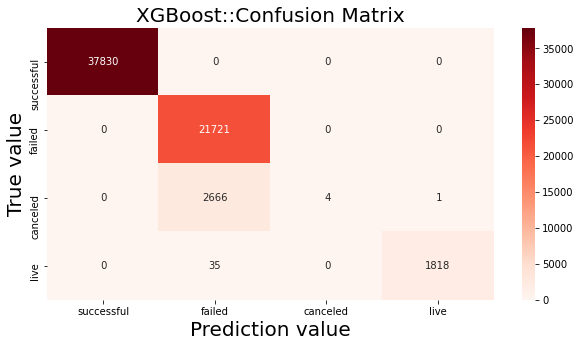

In [ ]:
import xgboost as xgb
XGB = xgb.XGBClassifier(random_state=0, eval_metric='mlogloss')
XGB.fit(X_train, y_train)
y_predict = XGB.predict(X_test)

accuracy_training = XGB.score(X_test, y_test, sample_weight=None)
accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)
precision = precision_score(y_true=y_test, y_pred=y_predict,average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_predict, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_predict, average='weighted')
roc_auc = roc_auc_score(y_test, XGB.predict_proba(X_test), multi_class='ovr')

key = 'xgboost'
training_accuracy_list[key] = accuracy_training
accuracy_list[key] = accuracy
precision_list[key] = precision
recall_list[key] = recall
f1_list[key] = f1
roc_auc_list[key] = roc_auc
classification_reports[key] = classification_report(y_test, y_predict, output_dict=True)

print('Training Accuracy: ' + str(accuracy_training))
print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1: ' + str(f1))
print('ROC_AUC: ' + str(roc_auc))
print(classification_reports['xgboost'])

# Confusion matrix
plt.figure(figsize=(10,5))
cf = confusion_matrix(y_true=y_test, y_pred=y_predict, labels=labels)
sns.heatmap(cf,fmt='2d', annot=True, cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediction value',fontsize=20)
plt.ylabel('True value',fontsize=20)
plt.title('XGBoost::Confusion Matrix',fontsize=20)
plt.show()


### Logistic Regression (One vs Rest)

Training Accuracy: 0.9272571205618416
Accuracy: 0.9272571205618416
Precision: 0.8895924482847163
Recall: 0.9272571205618416
F1: 0.9040069489015446
ROC_AUC: 0.8314377097713492
{'canceled': {'precision': 0.07446808510638298, 'recall': 0.002620741295394983, 'f1-score': 0.005063291139240506, 'support': 2671}, 'failed': {'precision': 0.840158259149357, 'recall': 0.9776253395331707, 'f1-score': 0.9036939313984168, 'support': 21721}, 'live': {'precision': 0.41586538461538464, 'recall': 0.1867242309767944, 'f1-score': 0.25772811918063315, 'support': 1853}, 'successful': {'precision': 0.9987326398056714, 'recall': 0.9998942638117896, 'f1-score': 0.9993131142343864, 'support': 37830}, 'accuracy': 0.9272571205618416, 'macro avg': {'precision': 0.582306092169199, 'recall': 0.5417161439042875, 'f1-score': 0.5414496139881693, 'support': 64075}, 'weighted avg': {'precision': 0.8895924482847163, 'recall': 0.9272571205618416, 'f1-score': 0.9040069489015446, 'support': 64075}}


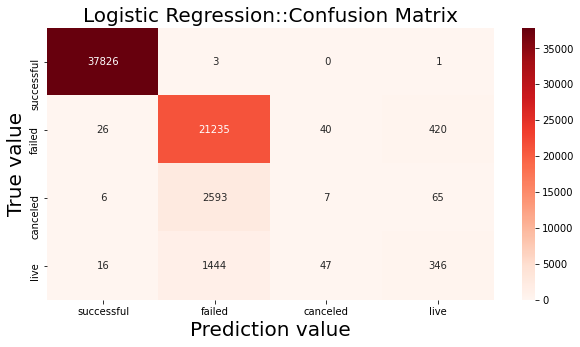

In [ ]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(multi_class='ovr', random_state=10, max_iter=10000)
LR.fit(X_train, y_train)
y_predict = LR.predict(X_test)

accuracy_training = LR.score(X_test, y_test, sample_weight=None)
accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)
precision = precision_score(y_true=y_test, y_pred=y_predict,average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_predict, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_predict, average='weighted')
roc_auc = roc_auc_score(y_test, LR.predict_proba(X_test), multi_class='ovr')

key = 'logistic_regression'
training_accuracy_list[key] = accuracy_training
accuracy_list[key] = accuracy
precision_list[key] = precision
recall_list[key] = recall
f1_list[key] = f1
roc_auc_list[key] = roc_auc
classification_reports[key] = classification_report(y_test, y_predict, output_dict=True)

print('Training Accuracy: ' + str(accuracy_training))
print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1: ' + str(f1))
print('ROC_AUC: ' + str(roc_auc))
print(classification_reports['logistic_regression'])

# Confusion matrix
plt.figure(figsize=(10,5))
cf = confusion_matrix(y_true=y_test, y_pred=y_predict, labels=labels)
sns.heatmap(cf,fmt='2d', annot=True, cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediction value',fontsize=20)
plt.ylabel('True value',fontsize=20)
plt.title('Logistic Regression::Confusion Matrix',fontsize=20)
plt.show()



### ANN with Adam classifier

Training Accuracy: 0.8742255169722981
Accuracy: 0.8742255169722981
Precision: 0.8760791491022002
Recall: 0.8742255169722981
F1: 0.8584148493935904
ROC_AUC: 0.9116682121640843
{'canceled': {'precision': 0.5, 'recall': 0.0007487832272557095, 'f1-score': 0.0014953271028037385, 'support': 2671}, 'failed': {'precision': 0.7504927079227434, 'recall': 0.9642281662906864, 'f1-score': 0.8440396550334488, 'support': 21721}, 'live': {'precision': 0.9991883116883117, 'recall': 0.664328116567728, 'f1-score': 0.7980551053484604, 'support': 1853}, 'successful': {'precision': 0.9687106378106034, 'recall': 0.8945017182130585, 'f1-score': 0.9301283637063301, 'support': 37830}, 'accuracy': 0.8742255169722981, 'macro avg': {'precision': 0.8045979143554147, 'recall': 0.6309516960746822, 'f1-score': 0.6434296127977608, 'support': 64075}, 'weighted avg': {'precision': 0.8760791491022002, 'recall': 0.8742255169722981, 'f1-score': 0.8584148493935904, 'support': 64075}}


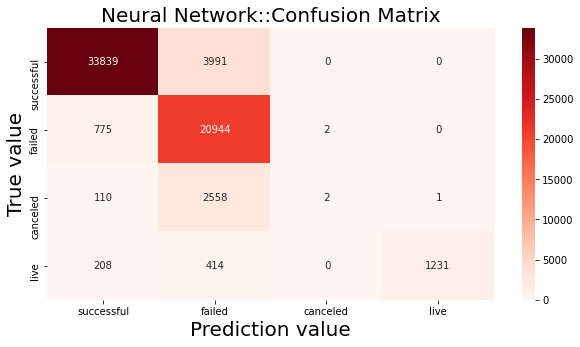

In [ ]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(solver='adam', random_state=42)
MLP.fit(X_train, y_train)
y_predict = MLP.predict(X_test)

accuracy_training = MLP.score(X_test, y_test, sample_weight=None)
accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)
precision = precision_score(y_true=y_test, y_pred=y_predict,average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_predict, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_predict, average='weighted')
roc_auc = roc_auc_score(y_test, MLP.predict_proba(X_test), multi_class='ovr')

key = 'neural_network'
training_accuracy_list[key] = accuracy_training
accuracy_list[key] = accuracy
precision_list[key] = precision
recall_list[key] = recall
f1_list[key] = f1
roc_auc_list[key] = roc_auc
classification_reports[key] = classification_report(y_test, y_predict, output_dict=True)

print('Training Accuracy: ' + str(accuracy_training))
print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1: ' + str(f1))
print('ROC_AUC: ' + str(roc_auc))
print(classification_reports['neural_network'])

# Confusion matrix
plt.figure(figsize=(10,5))
cf = confusion_matrix(y_true=y_test, y_pred=y_predict, labels=labels)
sns.heatmap(cf,fmt='2d', annot=True, cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediction value',fontsize=20)
plt.ylabel('True value',fontsize=20)
plt.title('Neural Network::Confusion Matrix',fontsize=20)
plt.show()


### Naive Bayes

Training Accuracy: 0.8148107686305112
Accuracy: 0.8148107686305112
Precision: 0.8740030902092903
Recall: 0.8148107686305112
F1: 0.8379170565657862
ROC_AUC: 0.7994220464811036
{'canceled': {'precision': 0.11923276308968378, 'recall': 0.0861100711344066, 'f1-score': 0.1, 'support': 2671}, 'failed': {'precision': 0.8599004855823992, 'recall': 0.6603747525436214, 'f1-score': 0.7470444247695434, 'support': 21721}, 'live': {'precision': 0.0743288816943208, 'recall': 0.29735563950350785, 'f1-score': 0.11892941938268943, 'support': 1853}, 'successful': {'precision': 0.9745611268790076, 'recall': 0.9802802008987576, 'f1-score': 0.9774122980416964, 'support': 37830}, 'accuracy': 0.8148107686305112, 'macro avg': {'precision': 0.5070058143113528, 'recall': 0.5060301660200733, 'f1-score': 0.4858465355484823, 'support': 64075}, 'weighted avg': {'precision': 0.8740030902092903, 'recall': 0.8148107686305112, 'f1-score': 0.8379170565657862, 'support': 64075}}


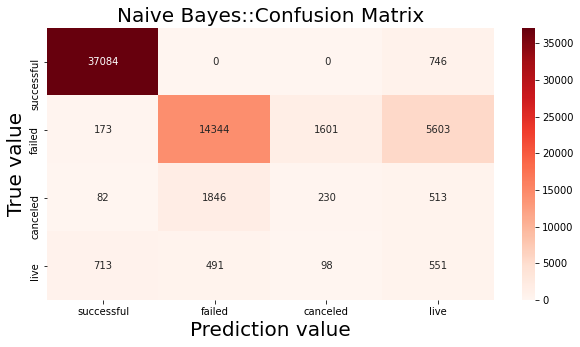

In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(X_train, y_train)
y_predict = NB.predict(X_test)

accuracy_training = NB.score(X_test, y_test, sample_weight=None)
accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)
precision = precision_score(y_true=y_test, y_pred=y_predict,average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_predict, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_predict, average='weighted')
roc_auc = roc_auc_score(y_test, NB.predict_proba(X_test), multi_class='ovr')

key = 'naive_bayes'
training_accuracy_list[key] = accuracy_training
accuracy_list[key] = accuracy
precision_list[key] = precision
recall_list[key] = recall
f1_list[key] = f1
roc_auc_list[key] = roc_auc
classification_reports[key] = classification_report(y_test, y_predict, output_dict=True)

print('Training Accuracy: ' + str(accuracy_training))
print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1: ' + str(f1))
print('ROC_AUC: ' + str(roc_auc))
print(classification_reports['naive_bayes'])

# Confusion matrix
plt.figure(figsize=(10,5))
cf = confusion_matrix(y_true=y_test, y_pred=y_predict, labels=labels)
sns.heatmap(cf,fmt='2d', annot=True, cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediction value',fontsize=20)
plt.ylabel('True value',fontsize=20)
plt.title('Naive Bayes::Confusion Matrix',fontsize=20)
plt.show()

In [ ]:
training_accuracy_list

{'decision_tree': 0.9990569066538245,
 'knn': 0.9048614904408896,
 'logistic_regression': 0.9272571205618416,
 'naive_bayes': 0.8148107686305112,
 'neural_network': 0.8742255169722981,
 'random_forest': 0.9570815450643777,
 'xgboost': 0.9578306671868904}

In [ ]:
accuracy_list

{'decision_tree': 0.9292235661334374,
 'knn': 0.9048614904408896,
 'logistic_regression': 0.9272571205618416,
 'naive_bayes': 0.8148107686305112,
 'neural_network': 0.8742255169722981,
 'random_forest': 0.9570815450643777,
 'xgboost': 0.9578306671868904}

In [ ]:
precision_list

{'decision_tree': 0.9327346339335251,
 'knn': 0.8794551634957855,
 'logistic_regression': 0.8895924482847163,
 'naive_bayes': 0.8740030902092903,
 'neural_network': 0.8760791491022002,
 'random_forest': 0.9368893323327087,
 'xgboost': 0.9624924512323154}

In [ ]:
recall_list

{'decision_tree': 0.9292235661334374,
 'knn': 0.9048614904408896,
 'logistic_regression': 0.9272571205618416,
 'naive_bayes': 0.8148107686305112,
 'neural_network': 0.8742255169722981,
 'random_forest': 0.9570815450643777,
 'xgboost': 0.9578306671868904}

In [ ]:
f1_list

{'decision_tree': 0.930935961484046,
 'knn': 0.8909884444995094,
 'logistic_regression': 0.9040069489015446,
 'naive_bayes': 0.8379170565657862,
 'neural_network': 0.8584148493935904,
 'random_forest': 0.9403985414118685,
 'xgboost': 0.9383125003322752}

In [ ]:
roc_auc_list

{'decision_tree': 0.8764498820583728,
 'knn': 0.8383986978351647,
 'logistic_regression': 0.8314377097713492,
 'naive_bayes': 0.7994220464811036,
 'neural_network': 0.9116682121640843,
 'random_forest': 0.964733782137176,
 'xgboost': 0.9691030279863065}

## Comparison between algorithms and metrics
### Succesful Projects

[100.0, 100.0, 98.09473959696415, 100.0, 99.87326398056715, 96.87106378106034, 97.45611268790077]
[100.0, 100.0, 98.58495528669121, 100.0, 99.93131142343864, 93.01283637063301, 97.74122980416963]
[100.0, 100.0, 99.08009516256939, 100.0, 99.98942638117896, 89.45017182130584, 98.02802008987575]


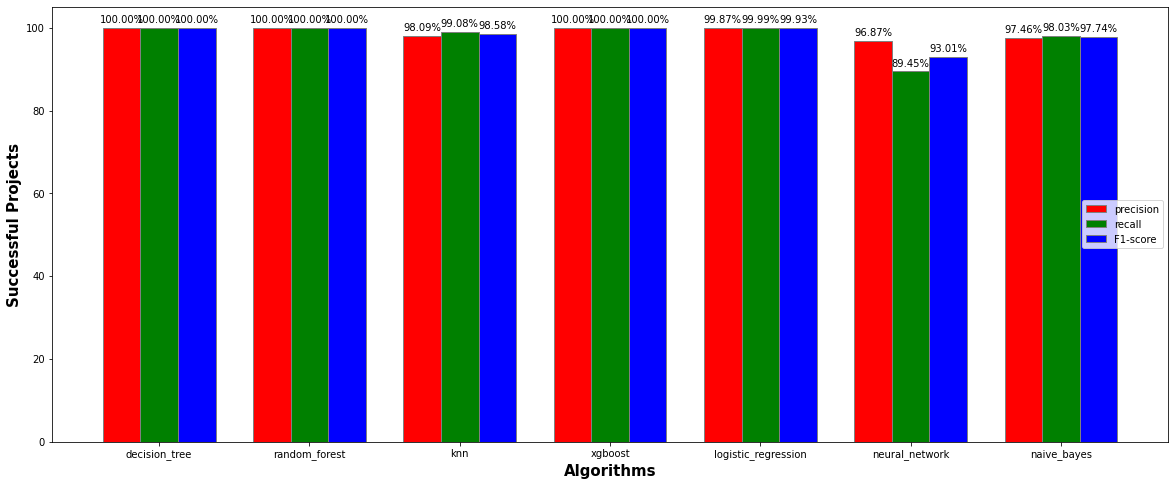

In [ ]:
precisions = []
recalls = []
f1s = []
algos = []
project_type = 'successful'
for k, v in classification_reports.items():
    precisions.append(v[project_type]['precision'] * 100)
    recalls.append(v[project_type]['recall'] * 100)
    f1s.append(v[project_type]['f1-score'] * 100)
    algos.append(k)

print(precisions)
print(f1s)
print(recalls)

barWidth = 0.25
br1 = np.arange(len(precisions))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots(figsize =(20, 8))

r1 = ax.bar(br1, precisions, color ='r', width = barWidth,
        edgecolor ='grey', label ='precision')
r2 = ax.bar(br2, recalls, color ='g', width = barWidth,
        edgecolor ='grey', label ='recall')
r3 = ax.bar(br3, f1s, color ='b', width = barWidth,
        edgecolor ='grey', label ='F1-score')

autolabel(r1)
autolabel(r2)
autolabel(r3)

plt.xlabel('Algorithms', fontweight ='bold', fontsize = 15)
plt.ylabel('Successful Projects', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(precisions))], algos)
 
plt.legend(loc=7)
plt.show()
  

### Failed Projects

[90.16914307074106, 89.26827249399885, 85.84616693610143, 88.94029972975186, 84.0158259149357, 75.04927079227434, 85.99004855823992]
[89.5021218375345, 94.01739206241963, 89.23430694054436, 94.14645775090479, 90.36939313984168, 84.40396550334488, 74.70444247695434]
[88.84489664380094, 99.30021638046131, 92.90087933336403, 100.0, 97.76253395331706, 96.42281662906865, 66.03747525436215]


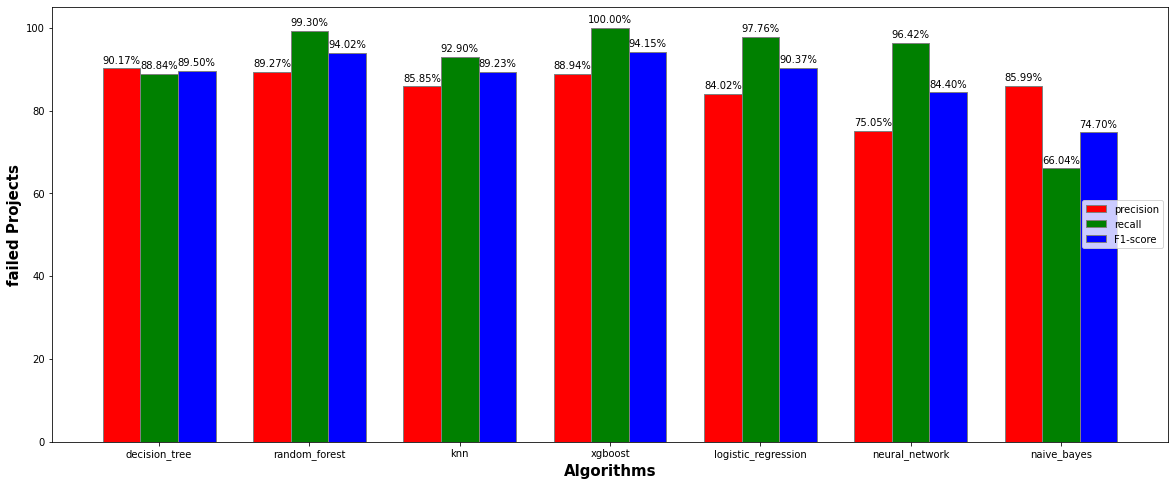

In [ ]:
precisions = []
recalls = []
f1s = []
algos = []
project_type = 'failed'
for k, v in classification_reports.items():
    precisions.append(v[project_type]['precision'] * 100)
    recalls.append(v[project_type]['recall'] * 100)
    f1s.append(v[project_type]['f1-score'] * 100)
    algos.append(k)

print(precisions)
print(f1s)
print(recalls)

barWidth = 0.25
br1 = np.arange(len(precisions))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots(figsize =(20, 8))

r1 = ax.bar(br1, precisions, color ='r', width = barWidth,
        edgecolor ='grey', label ='precision')
r2 = ax.bar(br2, recalls, color ='g', width = barWidth,
        edgecolor ='grey', label ='recall')
r3 = ax.bar(br3, f1s, color ='b', width = barWidth,
        edgecolor ='grey', label ='F1-score')

autolabel(r1)
autolabel(r2)
autolabel(r3)

plt.xlabel('Algorithms', fontweight ='bold', fontsize = 15)
plt.ylabel(f'%s Projects' % project_type, fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(precisions))], algos)
 
plt.legend(loc=7)
plt.show()
  

### Canceled Projects

[19.143239625167336, 35.9504132231405, 11.17408906882591, 100.0, 7.446808510638298, 50.0, 11.923276308968378]
[20.215585792542853, 5.9732234809474765, 7.066052227342551, 0.2990654205607477, 0.5063291139240507, 0.14953271028037385, 10.0]
[21.41520029951329, 3.257207038562336, 5.166604268064395, 0.1497566454511419, 0.2620741295394983, 0.07487832272557095, 8.611007113440659]


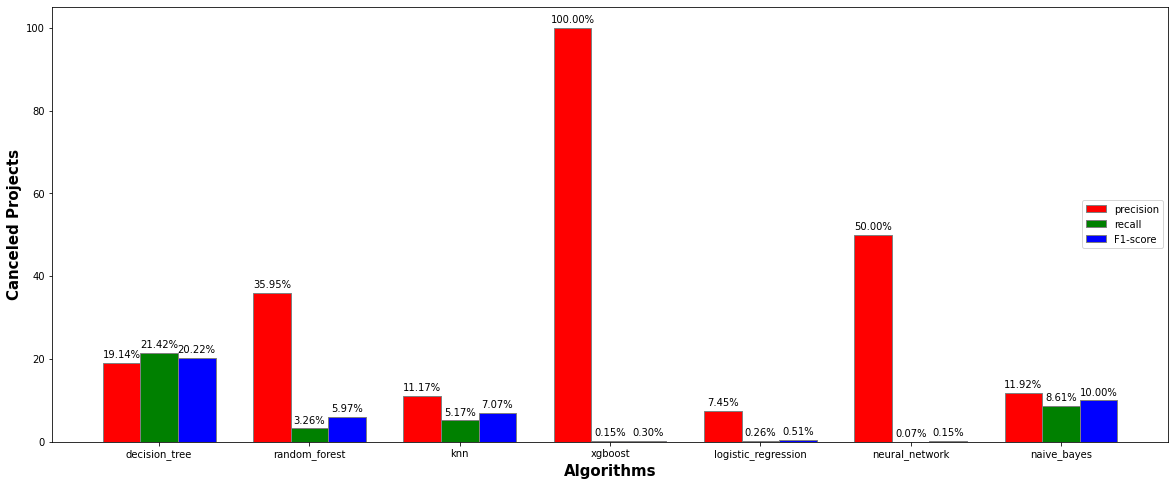

In [ ]:
precisions = []
recalls = []
f1s = []
algos = []
project_type = 'canceled'
for k, v in classification_reports.items():
    precisions.append(v[project_type]['precision'] * 100)
    recalls.append(v[project_type]['recall'] * 100)
    f1s.append(v[project_type]['f1-score'] * 100)
    algos.append(k)

print(precisions)
print(f1s)
print(recalls)

barWidth = 0.25
br1 = np.arange(len(precisions))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots(figsize =(20, 8))

r1 = ax.bar(br1, precisions, color ='r', width = barWidth,
        edgecolor ='grey', label ='precision')
r2 = ax.bar(br2, recalls, color ='g', width = barWidth,
        edgecolor ='grey', label ='recall')
r3 = ax.bar(br3, f1s, color ='b', width = barWidth,
        edgecolor ='grey', label ='F1-score')

autolabel(r1)
autolabel(r2)
autolabel(r3)

plt.xlabel('Algorithms', fontweight ='bold', fontsize = 15)
plt.ylabel('Canceled Projects', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(precisions))], algos)
 
plt.legend(loc=7)
plt.show()
  

### Live Projects

[99.19137466307278, 99.89136338946226, 16.014234875444842, 99.9450247388675, 41.58653846153847, 99.91883116883116, 7.432888169432079]
[99.24487594390507, 99.56686518678939, 12.092710782667117, 99.01960784313725, 25.772811918063315, 79.80551053484604, 11.892941938268944]
[99.29843497031841, 99.24446842957366, 9.713977334052887, 98.11117107393416, 18.672423097679438, 66.4328116567728, 29.735563950350784]


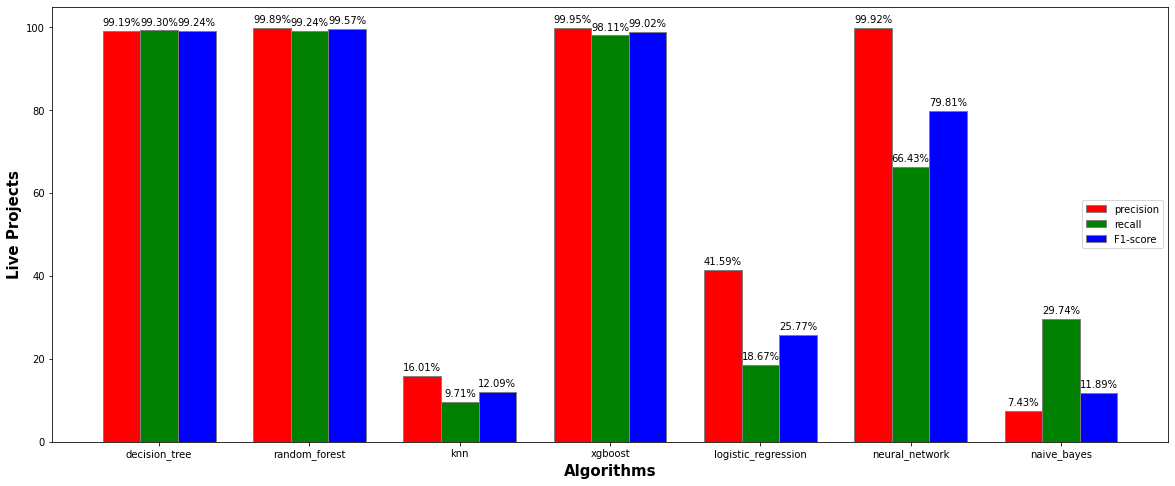

In [ ]:
precisions = []
recalls = []
f1s = []
algos = []
project_type = 'live'
for k, v in classification_reports.items():
    precisions.append(v[project_type]['precision'] * 100)
    recalls.append(v[project_type]['recall'] * 100)
    f1s.append(v[project_type]['f1-score'] * 100)
    algos.append(k)

print(precisions)
print(f1s)
print(recalls)

barWidth = 0.25
br1 = np.arange(len(precisions))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots(figsize =(20, 8))

r1 = ax.bar(br1, precisions, color ='r', width = barWidth,
        edgecolor ='grey', label ='precision')
r2 = ax.bar(br2, recalls, color ='g', width = barWidth,
        edgecolor ='grey', label ='recall')
r3 = ax.bar(br3, f1s, color ='b', width = barWidth,
        edgecolor ='grey', label ='F1-score')

autolabel(r1)
autolabel(r2)
autolabel(r3)

plt.xlabel('Algorithms', fontweight ='bold', fontsize = 15)
plt.ylabel('Live Projects', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(precisions))], algos)
 
plt.legend(loc=7)
plt.show()
  